[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mbarbetti/LNHunter/blob/master/binary_classification.ipynb)

# Binary classification

## Data loading and preparation

In [23]:
import numpy as np
import pandas as pd

import os
import pickle

data_dir  = "./data"
data_file = "db_mediastinalbulky_v2-reduced.pkl" 
file_path = os.path.join ( data_dir, data_file )

with open (file_path, "rb") as file:
  data = pickle.load (file)

data . info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119 entries, 0 to 118
Data columns (total 19 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   ID                               119 non-null    float64
 1   lymphoma_type                    119 non-null    float64
 2   age                              111 non-null    float64
 3   SUVmin (SUV)                     111 non-null    float64
 4   SUVmean (SUV)                    111 non-null    float64
 5   MTV (# vx)                       111 non-null    float64
 6   SMTV (mL/Kg) TOT                 111 non-null    float64
 7   CONVENTIONAL_SUVbwmin            115 non-null    float64
 8   CONVENTIONAL_SUVbwKurtosis       115 non-null    float64
 9   DISCRETIZED_HISTO_Kurtosis       110 non-null    float64
 10  SHAPE_Sphericity[onlyFor3DROI])  113 non-null    float64
 11  GLCM_Correlation                 113 non-null    float64
 12  GLRLM_SRE             

### Aggressive data cleaning 

In [24]:
data . dropna ( inplace = True )
data . info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101 entries, 0 to 118
Data columns (total 19 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   ID                               101 non-null    float64
 1   lymphoma_type                    101 non-null    float64
 2   age                              101 non-null    float64
 3   SUVmin (SUV)                     101 non-null    float64
 4   SUVmean (SUV)                    101 non-null    float64
 5   MTV (# vx)                       101 non-null    float64
 6   SMTV (mL/Kg) TOT                 101 non-null    float64
 7   CONVENTIONAL_SUVbwmin            101 non-null    float64
 8   CONVENTIONAL_SUVbwKurtosis       101 non-null    float64
 9   DISCRETIZED_HISTO_Kurtosis       101 non-null    float64
 10  SHAPE_Sphericity[onlyFor3DROI])  101 non-null    float64
 11  GLCM_Correlation                 101 non-null    float64
 12  GLRLM_SRE             

### Splitting into train-set and test-set

In [142]:
cols = list ( data.columns )
X_cols = cols[2:]
y_cols = "lymphoma_type"

binary_class = (data[y_cols] != 2)   # exclude GZ class

X = data[binary_class][X_cols] . to_numpy()
y = data[binary_class][y_cols] . to_numpy() . flatten()

ratio = len(y[y == 3]) / len(y[y == 1])
print ( "Label ratio on data-set : {:.1f}%" . format (100 * ratio) )

Label ratio on data-set : 41.5%


In [143]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split ( X, y, test_size = 0.2, random_state = 42 )

ratio_train = len(y_train[y_train == 3]) / len(y_train[y_train == 1])
print ( "Label ratio on train-set : {:.1f}%" . format (100 * ratio_train) )

ratio_test = len(y_test[y_test == 3]) / len(y_test[y_test == 1])
print ( "Label ratio on test-set  : {:.1f}%" . format (100 * ratio_test) )

Label ratio on train-set : 46.0%
Label ratio on test-set  : 26.7%


In [144]:
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit ( n_splits = 1, test_size = 0.2, random_state = 42 )
for idx_train, idx_test in sss . split ( X, y ):
    X_train , y_train = X[idx_train] , y[idx_train]
    X_test  , y_test  = X[idx_test]  , y[idx_test]

ratio_train = len(y_train[y_train == 3]) / len(y_train[y_train == 1])
print ( "Label ratio on train-set : {:.1f}%" . format (100 * ratio_train) )

ratio_test = len(y_test[y_test == 3]) / len(y_test[y_test == 1])
print ( "Label ratio on test-set  : {:.1f}%" . format (100 * ratio_test) )

Label ratio on train-set : 40.4%
Label ratio on test-set  : 46.2%


## Simple binary classification

In [99]:
%matplotlib inline 
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score

### Display trained model score
def display_score ( model_name: str, scores: list ):
    str_len = len ( model_name )
    print ( "+--" + "-" * str_len + "--+")
    print ( "|  {}  |" . format (model_name) )
    print ( "+--" + "-" * str_len + "--+")
    print ( "| Scores : {}" . format ( scores ) )
    print ( "| Mean   : {:.3f}" . format ( np.mean(scores) ) )
    print ( "| Std    : {:.3f}" . format ( np.std (scores) ) )
    print ( "+--- - -")

### Gradient Boosted Decision Trees

In [145]:
from sklearn.ensemble import GradientBoostingClassifier

clf_gbdt = GradientBoostingClassifier (
                                        learning_rate = 0.3 ,
                                        n_estimators = 100  ,
                                        criterion = 'friedman_mse' ,
                                        max_leaf_nodes = 10 ,
                                        max_depth = 5       ,
                                      )

scores = cross_val_score ( clf_gbdt, X_train, y_train, scoring = "accuracy", cv = 4 )

display_score ( model_name = "GBDT Classifier", scores = scores )

+-------------------+
|  GBDT Classifier  |
+-------------------+
| Scores : [0.73684211 0.72222222 0.83333333 0.77777778]
| Mean   : 0.768
| Std    : 0.043
+--- - -


[[44  6]
 [12 11]]


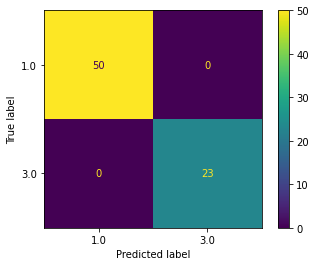

In [64]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

from sklearn.metrics import plot_confusion_matrix

y_train_pred = cross_val_predict(model, X_train, y_train, cv=3)

print ( confusion_matrix(y_train, y_train_pred) )

plot_confusion_matrix (model, X_train, y_train)
plt.show()

### Support Vector Machines

In [147]:
from sklearn.svm import SVC

clf_svm = SVC()

scores = cross_val_score ( clf_svm, X_train, y_train, scoring = "accuracy", cv = 4 )

display_score ( model_name = "SVM Classifier", scores = scores )

+------------------+
|  SVM Classifier  |
+------------------+
| Scores : [0.68421053 0.72222222 0.72222222 0.72222222]
| Mean   : 0.713
| Std    : 0.016
+--- - -


### Model evaluation

In [146]:
from sklearn.metrics import accuracy_score

#final_predictions = final_model . predict ( X_test )
#final_scores = accuracy_score ( y_test, final_predictions )

#display_score ( model_name = "Best Classifier", scores = final_scores )

### Model export

In [111]:
model_dir = "./models"
#exp_model_file = "model_test.pkl"
#exp_model_path = os.path.join ( model_dir, exp_model_file )

#pickle . dump ( model, open ( exp_model_path, "wb" ) )